Setup

In [ ]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import shap

Load sick and healthy patients

In [2]:
with open("data/eid_sick") as f:
    eid_sick = list(map(int, f.read().split('\n')))

with open("data/eid_healthy") as f:
    eid_healthy = list(map(int, f.read().split('\n')))

len(eid_sick), len(eid_healthy)

(26314, 476056)

Load column & their descriptions

In [3]:
with open('data/my_columns') as f:
    columns = [col for col in f.read().split('\n')]

len(columns)

787

In [4]:
with open('data/my_fields') as f:
    content = f.read().split('\n')
    fields = [line for line in content if len(line) > 0 and line[0] != '#']
    field_desc = [line.split('\t') for line in fields]

    column_desc = {
        f'{field}-0.0': desc 
        for field, desc in field_desc 
        if f'{field}-0.0' in columns
    }

len(column_desc)

232

Read my data

In [ ]:
df_sick = pd.read_csv('data/sick_data.csv', 
                      usecols=['eid'] + list(column_desc.keys()), 
                      index_col=['eid'])
df_healthy = pd.read_csv('data/my_data.csv', 
                         usecols=['eid'] + list(column_desc.keys()), 
                         index_col=['eid'],
                         nrows=2 * len(df_sick))

Drop blood pressure signal

In [6]:
column_desc['4205-0.0']

'Pulse wave pressure versus time response curve'

In [7]:
df_sick.drop(columns=['4205-0.0'], inplace=True)
df_healthy.drop(columns=['4205-0.0'], inplace=True)

Reduce healthy data

In [8]:
df_healthy = df_healthy.loc[list(set(eid_healthy) & set(df_healthy.index))[:len(df_sick)]]

Add column of diagnosis

In [9]:
df_sick['diagnosis'] = 1
df_healthy['diagnosis'] = 0

Merge sick and healthy group to one dataframe

In [10]:
df_raw = pd.concat([df_sick, df_healthy])
len(df_raw), len(df_raw) == 2 * len(df_sick)

(52628, True)

Fill all null values with 0

In [11]:
df_raw.fillna(0, inplace=True)

Check balance

In [12]:
print(f"all: {len(df_raw)}")
print(f"sick: {df_raw['diagnosis'].sum()}")
print(f"healthy: {len(df_raw) - df_raw['diagnosis'].sum()}")

all: 52628
sick: 26314
healthy: 26314


Fix weird non-numeric values

In [13]:
raw_data = df_raw.to_numpy()

In [14]:
for i, xi in enumerate(raw_data):
    for c, xic in enumerate(xi):
        try:
            float(xic)
        except:
            print(i, c, xic)

16491 3 ..2870
16788 3 ..2870
43784 3 ..2870
44357 3 ..2870


In [15]:
raw_data[raw_data == '..2870'] = 2870

Split to train/val/test

In [16]:
train_data, test_data = train_test_split(raw_data.astype(np.float64), test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

Check balance once again

In [17]:
print(f"train sick: {int(y_train.sum())}/{len(y_train)}")
print(f"val sick: {int(y_val.sum())}/{len(y_val)}")
print(f"test sick: {int(y_test.sum())}/{len(y_test)}")

train sick: 16811/33681
val sick: 4264/8421
test sick: 5239/10526


Normalize features

In [18]:
scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

Try Logistic Regression with L1 regularization

In [48]:
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train_norm, y_train)

In [91]:
print(f'train score: {100 * lr_l1.score(X_train_norm, y_train):.2f}, f1: {100 * f1_score(y_train, lr_l1.predict(X_train_norm)):.2f}')
print(f'val score: {100 * lr_l1.score(X_val_norm, y_val):.2f}, f1: {100 * f1_score(y_val, lr_l1.predict(X_val_norm)):.2f}')

train score: 72.54, f1: 72.18
val score: 72.02, f1: 72.11


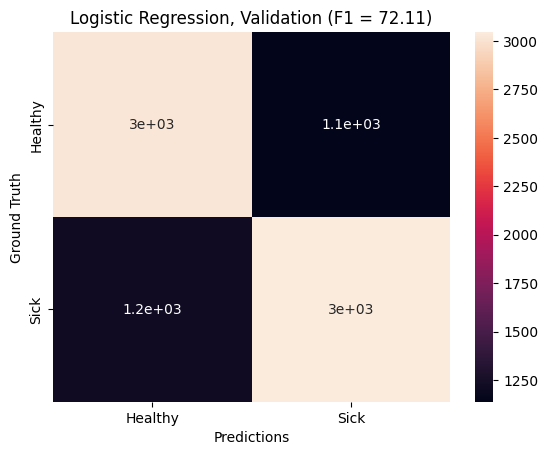

In [94]:
cm_lr = confusion_matrix(y_val, lr_l1.predict(X_val_norm))
f1 = f1_score(y_val, lr_l1.predict(X_val_norm))

sns.heatmap(cm_lr, annot=cm_lr, xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
plt.ylabel("Ground Truth")
plt.xlabel("Predictions")
plt.title(f"Logistic Regression, Validation (F1 = {100 * f1:.2f})")
plt.show()

Read coefficients

In [53]:
# sort columns by coefficient
col_coef = sorted(list(zip(df_raw.columns, lr_l1.coef_[0])), key=lambda x: x[1], reverse=True)

# replace columns with description
field_coef = [(column_desc[col], coef) for col, coef in col_coef]


for f, c in field_coef[:10]:
    print(f"{f} = {c:.4f}")

print('...')

for f, c in field_coef[-10:]:
    print(f"{f} = {c:.4f}")


Systolic blood pressure, automated reading = 0.6830
Systolic blood pressure, manual reading = 0.5771
Waist circumference = 0.4980
Pack years of smoking = 0.4627
Haemoglobin concentration = 0.3157
Position of the shoulder on the pulse waveform = 0.2747
Chest pain or discomfort = 0.2170
Age stopped smoking = 0.2142
Red blood cell (erythrocyte) distribution width = 0.2101
Testosterone = 0.2071
...
Red blood cell (erythrocyte) count = -0.2059
HDL cholesterol = -0.2314
Pulse rate = -0.2479
Pulse rate, automated reading = -0.3262
Mean corpuscular haemoglobin concentration = -0.3509
Hip circumference = -0.3748
Diastolic blood pressure, automated reading = -0.4086
Diastolic blood pressure, manual reading = -0.4627
Pack years adult smoking as proportion of life span exposed to smoking = -0.5160
Cholesterol = -0.5589


Reduce number of features

In [105]:
coef_ths = [0.01, 0.05, 0.1, 0.2]
lrs = []

for coef_th in coef_ths:

    feature_mask = np.abs(lr_l1.coef_[0]) > coef_th

    X_train_reduced = X_train_norm[:, feature_mask]
    X_val_reduced = X_val_norm[:, feature_mask]

    lr = LogisticRegression(max_iter=1000).fit(X_train_reduced, y_train)
    lrs.append(lr)

    print(f'Using only {feature_mask.sum()} features')
    print(f'\ttrain score: {100 * lr.score(X_train_reduced, y_train):.2f}, f1: {100 * f1_score(y_train, lr.predict(X_train_reduced)):.2f}')
    print(f'\tval score: {100 * lr.score(X_val_reduced, y_val):.2f}, f1: {100 * f1_score(y_val, lr.predict(X_val_reduced)):.2f}')
    

Using only 182 features
	train score: 72.59, f1: 72.21
	val score: 72.05, f1: 72.18
Using only 71 features
	train score: 72.09, f1: 71.68
	val score: 71.49, f1: 71.47
Using only 43 features
	train score: 71.87, f1: 71.43
	val score: 71.96, f1: 72.00
Using only 20 features
	train score: 69.64, f1: 69.35
	val score: 69.93, f1: 70.01


Try with different classifiers

In [23]:
classifiers = {
    "NB": GaussianNB(),
    "TREE": DecisionTreeClassifier(max_depth=5),
    "FOREST": RandomForestClassifier(max_depth=5, n_estimators=10),
    "ADA": AdaBoostClassifier(),
    "XGB": XGBClassifier()
}

for name, clf in classifiers.items():
    clf.fit(X_train_norm, y_train)
    print(f'\n{name}')
    print(F'\ttrain score: {100 * clf.score(X_train_norm, y_train):.2f} f1: {f1_score(y_train, clf.predict(X_train_norm)):.2f}') 
    print(f'\tval score: {100 * clf.score(X_val_norm, y_val):.2f}, f1: {f1_score(y_val, clf.predict(X_val_norm)):.2f}')


NB
	train score: 64.32 f1: 0.57
	val score: 64.51, f1: 0.58

TREE
	train score: 69.91 f1: 0.70
	val score: 69.52, f1: 0.70

FOREST
	train score: 70.43 f1: 0.70
	val score: 70.26, f1: 0.70

ADA
	train score: 72.75 f1: 0.72
	val score: 71.90, f1: 0.72

XGB
	train score: 91.75 f1: 0.92
	val score: 72.72, f1: 0.73


Recursive Feature Elimination

In [38]:
rfe_5_path = 'models/feature_selection/rfe_5_lr_norm_l1_liblin.pkl'

if os.path.exists(rfe_5_path):
    with open(rfe_5_path, 'rb') as f:
        rfe_5 = pickle.load(f)    

else:
    estimator_5 = LogisticRegression(penalty='l1', solver='liblinear')
    rfe_5 = RFE(estimator_5, step=5).fit(X_train_norm, y_train)
    
    with open(rfe_5_path, 'wb') as f:
        pickle.dump(rfe_5, f, protocol=pickle.HIGHEST_PROTOCOL)
    
print(f'train score: {100 * rfe_5.score(X_train_norm, y_train):.2f}, f1: {100 * f1_score(y_train, rfe_5.predict(X_train_norm)):.2f}')
print(f'val score: {100 * rfe_5.score(X_val_norm, y_val):.2f}, f1: {100 * f1_score(y_val, rfe_5.predict(X_val_norm)):.2f}')

train score: 72.39, f1: 72.00
val score: 71.83, f1: 71.91


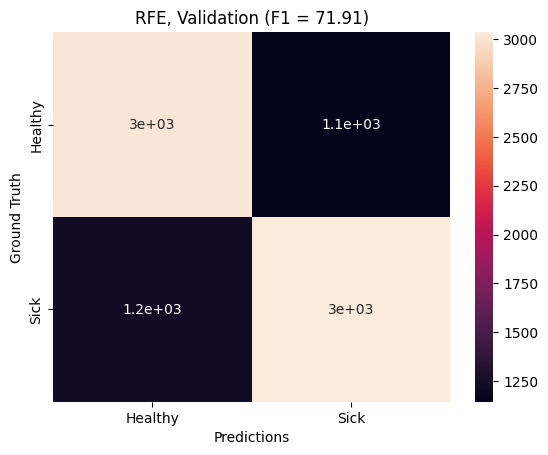

In [95]:
cm_rfe_5 = confusion_matrix(y_val, rfe_5.predict(X_val_norm))

sns.heatmap(cm_rfe_5, annot=cm_rfe_5, xticklabels=['Healthy', 'Sick'], yticklabels=['Healthy', 'Sick'])
plt.ylabel("Ground Truth")
plt.xlabel("Predictions")
plt.title(f"RFE, Validation (F1 = {100 * f1_score(y_val, rfe_5.predict(X_val_norm)):.2f})")
plt.show()

Hyperparameter Tuning

In [98]:
search_forest = RandomForestClassifier(random_state=42)
params = {
    'max_depth': stats.randint(5, 11),
    'n_estimators': stats.randint(10, 101),
    'min_samples_split': stats.randint(2, 11)
}

search = RandomizedSearchCV(search_forest, params, random_state=42, verbose=2).fit(X_train_norm, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..max_depth=8, min_samples_split=9, n_estimators=70; total time=   6.2s
[CV] END ..max_depth=8, min_samples_split=9, n_estimators=70; total time=   6.1s
[CV] END ..max_depth=8, min_samples_split=9, n_estimators=70; total time=   6.2s
[CV] END ..max_depth=8, min_samples_split=9, n_estimators=70; total time=   6.1s
[CV] END ..max_depth=8, min_samples_split=9, n_estimators=70; total time=   6.2s
[CV] END ..max_depth=9, min_samples_split=8, n_estimators=92; total time=   9.0s
[CV] END ..max_depth=9, min_samples_split=8, n_estimators=92; total time=   9.1s
[CV] END ..max_depth=9, min_samples_split=8, n_estimators=92; total time=   9.3s
[CV] END ..max_depth=9, min_samples_split=8, n_estimators=92; total time=   9.4s
[CV] END ..max_depth=9, min_samples_split=8, n_estimators=92; total time=   9.1s
[CV] END ..max_depth=7, min_samples_split=9, n_estimators=33; total time=   2.7s
[CV] END ..max_depth=7, min_samples_split=9, n_e

In [99]:
best_forest = search.best_estimator_

print(f'best params: {search.best_params_}')
print(f'best score: {100 * search.best_score_:.2f}')
print(f'train score: {100 * best_forest.score(X_train_norm, y_train):.2f} f1: {100 * f1_score(y_train, best_forest.predict(X_train_norm)):.2f}') 
print(f'val score: {100 * best_forest.score(X_val_norm, y_val):.2f} f1: {100 * f1_score(y_val, best_forest.predict(X_val_norm)):.2f}') 

best params: {'max_depth': 8, 'min_samples_split': 9, 'n_estimators': 70}
best score: 71.30
train score: 75.04 f1: 74.68
val score: 71.97 f1: 72.18


SHAP

In [126]:
np.bool = np.bool_
feature_names = [column_desc[col] for col in df_raw.columns[:-1]]

In [127]:
explainer_forest = shap.TreeExplainer(best_forest)
shap_vals_forest = explainer_forest.shap_values(X_test_norm)

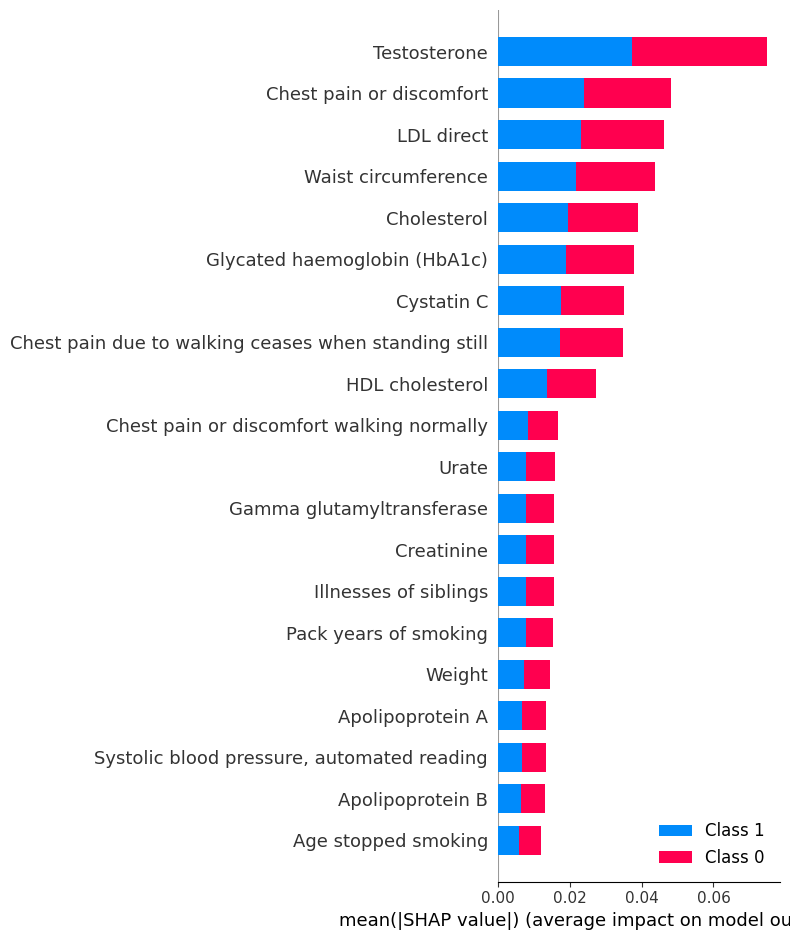

In [130]:
shap.summary_plot(shap_vals_forest, X_test_norm, feature_names=feature_names)